In [7]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import soundfile

import torch
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchaudio.transforms import MelSpectrogram, ComputeDeltas

from torch.optim.adamw import AdamW


import re
import json

import os
from os import listdir
from os.path import isfile, join

import math
import random

from pathlib import Path
from IPython.display import Audio

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt


import wave

from fastprogress import master_bar, progress_bar

import pandas as pd 
import os

from scipy.io import wavfile
from scipy import signal
import tqdm
import IPython
import re

import librosa

from torch.utils.data import DataLoader
import ast

import glob
import difflib

In [8]:
wake_words = [
    "fuck"
    ,"fucking"
    ,"ass"
    ,"bitch"
    ,"dick"
    ,"fag"
    ,"faggot"
    ,"shit"
    ,"cunt"
    ,"whore"
    ,"cock"
    ,"pussy"
    ,"cocksucker"

]

wake_words_sequence = ["0", "1", "2","3","4","5","6","7","8","9","10","11","12","13"]


In [9]:
wake_word_seq_map = dict(zip(wake_words, wake_words_sequence))
regex_pattern = r"\b(?:{})\b".format("|".join(map(re.escape, wake_words)))
pattern = re.compile(regex_pattern, flags=re.IGNORECASE)


def wake_words_search(pattern, word):
    try:
        return bool(pattern.search(word))
    except TypeError:
        return False

In [113]:
positive_train_data = pd.read_csv('cuss_word_time_stamp_wisper_true_1.csv')

negative_train_data = pd.read_csv('cuss_word_time_stamp_wisper_false.csv')

negative_train_data['timestamps'].apply(lambda x: {})

combined_train_data = pd.concat([positive_train_data, negative_train_data])


combined_train_data['timestamps'] = combined_train_data['timestamps'].apply(ast.literal_eval)
combined_train_data['timestamps'] = combined_train_data['timestamps'].apply(lambda x: {re.sub('[^\w\s]', '', key): value for key, value in x.items()})


In [114]:
test_ds = pd.read_csv('cuss_word_time_stamp_wisper.csv')
test_ds['timestamps'] = test_ds['timestamps'].apply(ast.literal_eval)
test_ds['timestamps'] = test_ds['timestamps'].apply(lambda x: {re.sub('[^\w\s]', '', key): value for key, value in x.items()})


In [115]:
def similar(a,b):
    seq = difflib.SequenceMatcher(None,a,b)
    return seq.ratio()

In [116]:
data_path = 'dataset/Data/'

In [117]:
key_pattern = re.compile(r"'(?P<key>[^']+)'")

def compute_labels(metadata, audio_data):
    label = 0 # by default negative label

    # if it is generated data then 
    if metadata['sentence'].lower() in wake_words:
        label = int(wake_word_seq_map[metadata['sentence'].lower()])
    else:
        # if the sentence has one wakeword get label and end timestamp
        wake_word_found = False
        for word in metadata['sentence'].lower().split():
            word = re.sub('\W+', '', word)
            for wake_word in wake_words:
                if similar(word, wake_word.lower()) >= 0.8 or word in wake_word.lower() or wake_word.lower() in word.lower(): 
                    wake_word_found = True

                    label = 1
                    if word in  metadata['timestamps']:
                        timestamps = metadata['timestamps']
                        if type(timestamps) == str:
                          #timestamps = json.loads(key_pattern.sub(r'"\g"', timestamps))
                            timestamps = eval(timestamps)
                        word_ts = timestamps[word]
                        audio_start_idx = int((word_ts['start'] * 1000) * sr / 1000)
                        audio_end_idx = int((word_ts['end'] * 1000) * sr / 1000)
                        audio_data = audio_data[audio_start_idx:audio_end_idx]
                    else: # if there are issues with word alignment, we might not get ts
                        label = 0 
            if label == 1:
                break
    return label, audio_data

class AudioCollator(object):
  def __init__(self, noise_set=None):
    self.noise_set = noise_set

  def __call__(self, batch):
    batch_tensor = {}
    window_size_ms = 750
    max_length = int(window_size_ms/1000 * sr)
    audio_tensors = []
    labels = []
    for sample in batch:
      # get audio_data in tensor format
      audio_data = librosa.core.load(data_path+sample['path'], sr=sr, mono=True)[0]
      # get the label and its audio
      label, audio_data = compute_labels(sample, audio_data)
      audio_data_length = audio_data.size / sr * 1000 #ms
  
      # below is to make sure that we always got length of 12000 
      # i.e 750 ms with sr 16000
      # trim to max_length
      if audio_data_length > window_size_ms:
        # randomly trim either at start and end
        if random.random() < 0.5:
          audio_data = audio_data[:max_length]
        else:
          audio_data = audio_data[audio_data.size-max_length:]
  
      # pad with zeros
      if audio_data_length < window_size_ms:
        # randomly either append or prepend
        if random.random() < 0.5:
          audio_data = np.append(audio_data, np.zeros(int(max_length - audio_data.size)))
        else:
          audio_data = np.append(np.zeros(int(max_length - audio_data.size)), audio_data)

      # Add noise
      if self.noise_set:
        noise_level =  random.randint(1, 5)/10 # 10 to 50%
        noise_sample = librosa.core.load(self.noise_set[random.randint(0,len(self.noise_set)-1)], sr=sr, mono=True)[0]
        # randomly select first or last seq of noise
        if random.random() < 0.5:
          audio_data = (1 - noise_level) * audio_data +  noise_level * noise_sample[:max_length]
        else:
          audio_data = (1 - noise_level) * audio_data +  noise_level * noise_sample[-max_length:]
  
      audio_tensors.append(torch.from_numpy(audio_data))
      labels.append(label)
  
    batch_tensor = {
        'audio': torch.stack(audio_tensors),
        'labels': torch.tensor(labels) 
    }
    
    return batch_tensor
     

In [118]:
train_ds = combined_train_data

In [119]:
hey_pattern = re.compile(r'\bfuck\b', flags=re.IGNORECASE)
fourth_pattern = re.compile(r'\bass\b', flags=re.IGNORECASE)
brain_pattern = re.compile(r'\bfucking\b', flags=re.IGNORECASE)

print(f"Total fuck word {(train_ds[[wake_words_search(hey_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total ass word {(train_ds[[wake_words_search(fourth_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total fucking word {(train_ds[[wake_words_search(brain_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")



Total fuck word 11.79841833957673 %
Total ass word 1.2486792815291519 %
Total fucking word 26.254282329587298 %


In [120]:
noise_test = glob.glob('dataset/MS-SNSD/noise_test/*.wav')
noise_train = glob.glob('dataset/MS-SNSD/noise_train/*.wav')


In [121]:
batch_size = 64
num_workers = 16

train_audio_collator = AudioCollator(noise_set=noise_train)
train_dl = tud.DataLoader(train_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  drop_last=True,
                  shuffle=True,
                  num_workers=num_workers,collate_fn=train_audio_collator)



test_audio_collator = AudioCollator(noise_set=noise_test)
test_dl = tud.DataLoader(test_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  num_workers=num_workers,
                  collate_fn=test_audio_collator)


In [122]:
sr = 24000

num_mels = 40 # https://en.wikipedia.org/wiki/Mel_scale
num_fft = 512 # window length - Fast Fourier Transform
hop_length = 200  # making hops of size hop_length each time to sample the next window

def audio_transform(audio_data):
  # Transformations
  # Mel-scale spectrogram is a combination of Spectrogram and mel scale conversion
  # 1. compute FFT - for each window to transform from time domain to frequency domain
  # 2. Generate Mel Scale - Take entire freq spectrum & seperate to n_mels evenly spaced
  #    frequencies. (not by distance on freq domain but distance as it is heard by human ear)
  # 3. Generate Spectrogram - For each window, decompose the magnitude of the signal
  #    into its components, corresponding to the frequencies in the mel scale. 
  mel_spectrogram  = MelSpectrogram(n_mels=num_mels,
                                    sample_rate=sr,
                                    n_fft=num_fft,
                                    hop_length=hop_length,
                                    norm='slaney')
  mel_spectrogram.to(device)
  log_mels = mel_spectrogram(audio_data.float()).add_(1e-7).log_().contiguous()
  # returns (channel, n_mels, time) 
  return log_mels.to(device)
     


In [123]:
from typing import Iterable
class ZmuvTransform(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('total', torch.zeros(1))
        self.register_buffer('mean', torch.zeros(1))
        self.register_buffer('mean2', torch.zeros(1))

    def update(self, data, mask=None):
        with torch.no_grad():
            if mask is not None:
                data = data * mask
                mask_size = mask.sum().item()
            else:
                mask_size = data.numel()
            self.mean = (data.sum() + self.mean * self.total) / (self.total + mask_size)
            self.mean2 = ((data ** 2).sum() + self.mean2 * self.total) / (self.total + mask_size)
            self.total += mask_size

    def initialize(self, iterable: Iterable[torch.Tensor]):
        for ex in iterable:
            self.update(ex)

    @property
    def std(self):
        return (self.mean2 - self.mean ** 2).sqrt()

    def forward(self, x):
        return (x - self.mean) / self.std


In [124]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [125]:
zmuv_audio_collator = AudioCollator()
zmuv_dl = tud.DataLoader(train_ds.to_dict(orient='records'),
                  batch_size=1,
                  num_workers=num_workers,
                  collate_fn=zmuv_audio_collator)

zmuv_transform = ZmuvTransform().to(device)
if Path("zmuv.pt.bin").exists():
    zmuv_transform.load_state_dict(torch.load(str("zmuv.pt.bin")))
else:
  for idx, batch in enumerate(zmuv_dl):
    zmuv_transform.update(batch['audio'].to(device))
  print(dict(zmuv_mean=zmuv_transform.mean, zmuv_std=zmuv_transform.std))
  torch.save(zmuv_transform.state_dict(), str("zmuv.pt.bin"))

print(f"Mean is {zmuv_transform.mean.item():0.6f}")
print(f"Standard Deviation is {zmuv_transform.std.item():0.6f}")


Mean is 0.000009
Standard Deviation is 0.099586


In [126]:
class CNN(nn.Module):
    def __init__(self, num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size):
        super(CNN, self).__init__()
        conv0 = nn.Conv2d(1, num_maps1, (8, 16), padding=(4, 0), stride=(2, 2), bias=True)
        pool = nn.MaxPool2d(2)
        conv1 = nn.Conv2d(num_maps1, num_maps2, (5, 5), padding=2, stride=(2, 1), bias=True)
        self.num_hidden_input = num_hidden_input
        self.encoder1 = nn.Sequential(conv0,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps1, affine=True))
        self.encoder2 = nn.Sequential(conv1,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps2, affine=True))
        self.output = nn.Sequential(nn.Linear(num_hidden_input, hidden_size),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(hidden_size, num_labels))
        
    def forward(self, x):
        x = x.permute(0, 1, 3, 2)  # change to (time, n_mels)
        # pass through first conv layer
        x1 = self.encoder1(x)
        # pass through second conv layer
        x2 = self.encoder2(x1)
        # flattening - keep first dim batch same, flatten last 3 dims
        x = x2.view(x2.size(0), -1)
        return self.output(x)

In [181]:
num_labels = 1 # oov
num_maps1  = 48
num_maps2  = 64
num_hidden_input =  1152
hidden_size = 128
model = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)


In [182]:
model.to(device)
model

CNN(
  (encoder1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(8, 16), stride=(2, 2), padding=(4, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_features=1152, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [36]:
summary(model.to('cuda'), input_size=(1,40,91))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 46, 13]           6,192
              ReLU-2           [-1, 48, 46, 13]               0
         MaxPool2d-3            [-1, 48, 23, 6]               0
         MaxPool2d-4            [-1, 48, 23, 6]               0
       BatchNorm2d-5            [-1, 48, 23, 6]              96
            Conv2d-6            [-1, 64, 12, 6]          76,864
              ReLU-7            [-1, 64, 12, 6]               0
         MaxPool2d-8             [-1, 64, 6, 3]               0
         MaxPool2d-9             [-1, 64, 6, 3]               0
      BatchNorm2d-10             [-1, 64, 6, 3]             128
           Linear-11                  [-1, 128]         147,584
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [183]:
learning_rate = 0.001
weight_decay = 0.0001 # Weight regularization
lr_decay = 0.95

criterion = nn.BCEWithLogitsLoss()
params = list(filter(lambda x: x.requires_grad, model.parameters()))

optimizer = AdamW(model.parameters(), learning_rate, weight_decay=weight_decay)

In [130]:

epochs = 20

# config for progress bar
mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']
x = []

training_losses = []
validation_losses = []

valid_mean_min = np.Inf

for epoch in mb:
  x.append(epoch)
  # Evaluate
  model.train()
  total_loss = torch.Tensor([0.0]).to(device)
  #pbar = tqdm(train_dl, total=len(train_dl), position=0, desc="Training", leave=True)
  for batch in progress_bar(train_dl, parent=mb):
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    # get mel spectograms
    mel_audio_data = audio_transform(audio_data)
    # do zmuv transform
    mel_audio_data = zmuv_transform(mel_audio_data)
    predicted_scores = model(mel_audio_data.unsqueeze(1))
    # get loss
    loss = criterion(predicted_scores, labels.long())

    optimizer.zero_grad()
    model.zero_grad()

    # backward propagation
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        total_loss += loss

  for group in optimizer.param_groups:
    group["lr"] *= lr_decay

  mean = total_loss / len(train_dl)
  print('epoch:',epoch,'loss:',mean.item())
  torch.save(model.state_dict(), 'checkpoint/checkpoint.pth')
  training_losses.append(mean.cpu())

epoch: 0 loss: 0.16042566299438477


KeyboardInterrupt: 

/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.49      0.96      0.65      1669
        stfu       0.98      0.70      0.82      5654

    accuracy                           0.76      7323
   macro avg       0.74      0.83      0.73      7323
weighted avg       0.87      0.76      0.78      7323



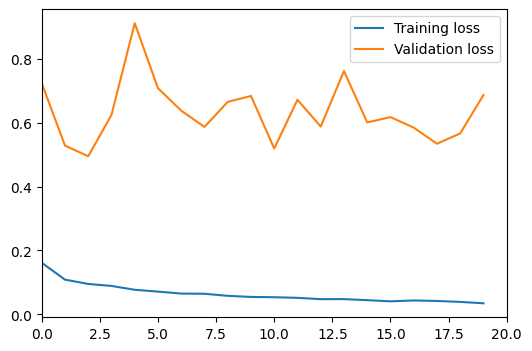

/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 0.723273).  Saving model ...


/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.52      0.94      0.67      3338
        stfu       0.98      0.74      0.84     11308

    accuracy                           0.79     14646
   macro avg       0.75      0.84      0.76     14646
weighted avg       0.87      0.79      0.80     14646



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (0.723273 --> 0.528035).  Saving model ...


/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.54      0.93      0.68      5007
        stfu       0.97      0.76      0.86     16962

    accuracy                           0.80     21969
   macro avg       0.76      0.85      0.77     21969
weighted avg       0.87      0.80      0.82     21969



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (0.528035 --> 0.494638).  Saving model ...


/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.54      0.94      0.68      6676
        stfu       0.98      0.76      0.85     22616

    accuracy                           0.80     29292
   macro avg       0.76      0.85      0.77     29292
weighted avg       0.88      0.80      0.82     29292



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.51      0.95      0.67      8345
        stfu       0.98      0.74      0.84     28270

    accuracy                           0.78     36615
   macro avg       0.75      0.84      0.75     36615
weighted avg       0.87      0.78      0.80     36615



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.52      0.94      0.67     10014
        stfu       0.98      0.74      0.84     33924

    accuracy                           0.79     43938
   macro avg       0.75      0.84      0.76     43938
weighted avg       0.87      0.79      0.81     43938



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.52      0.95      0.67     11683
        stfu       0.98      0.75      0.85     39578

    accuracy                           0.79     51261
   macro avg       0.75      0.85      0.76     51261
weighted avg       0.88      0.79      0.81     51261



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.53      0.95      0.68     13352
        stfu       0.98      0.75      0.85     45232

    accuracy                           0.80     58584
   macro avg       0.76      0.85      0.77     58584
weighted avg       0.88      0.80      0.81     58584



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.53      0.95      0.68     15021
        stfu       0.98      0.75      0.85     50886

    accuracy                           0.80     65907
   macro avg       0.76      0.85      0.77     65907
weighted avg       0.88      0.80      0.81     65907



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.53      0.95      0.68     16690
        stfu       0.98      0.75      0.85     56540

    accuracy                           0.80     73230
   macro avg       0.76      0.85      0.77     73230
weighted avg       0.88      0.80      0.81     73230



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.54      0.95      0.69     18359
        stfu       0.98      0.76      0.86     62194

    accuracy                           0.80     80553
   macro avg       0.76      0.86      0.77     80553
weighted avg       0.88      0.80      0.82     80553



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.54      0.95      0.69     20028
        stfu       0.98      0.76      0.86     67848

    accuracy                           0.81     87876
   macro avg       0.76      0.86      0.77     87876
weighted avg       0.88      0.81      0.82     87876



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.54      0.95      0.69     21697
        stfu       0.98      0.77      0.86     73502

    accuracy                           0.81     95199
   macro avg       0.76      0.86      0.78     95199
weighted avg       0.88      0.81      0.82     95199



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.55      0.95      0.69     23366
        stfu       0.98      0.77      0.86     79156

    accuracy                           0.81    102522
   macro avg       0.76      0.86      0.78    102522
weighted avg       0.88      0.81      0.82    102522



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.55      0.95      0.70     25035
        stfu       0.98      0.77      0.86     84810

    accuracy                           0.81    109845
   macro avg       0.77      0.86      0.78    109845
weighted avg       0.88      0.81      0.82    109845



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.55      0.95      0.70     26704
        stfu       0.98      0.77      0.86     90464

    accuracy                           0.81    117168
   macro avg       0.77      0.86      0.78    117168
weighted avg       0.88      0.81      0.83    117168



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.55      0.95      0.70     28373
        stfu       0.98      0.77      0.87     96118

    accuracy                           0.81    124491
   macro avg       0.77      0.86      0.78    124491
weighted avg       0.88      0.81      0.83    124491



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.56      0.95      0.70     30042
        stfu       0.98      0.78      0.87    101772

    accuracy                           0.82    131814
   macro avg       0.77      0.86      0.78    131814
weighted avg       0.88      0.82      0.83    131814



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.56      0.95      0.70     31711
        stfu       0.98      0.78      0.87    107426

    accuracy                           0.82    139137
   macro avg       0.77      0.86      0.79    139137
weighted avg       0.89      0.82      0.83    139137



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/l

Testing:   0%|          | 0/115 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.56      0.95      0.71     33380
        stfu       0.98      0.78      0.87    113080

    accuracy                           0.82    146460
   macro avg       0.77      0.87      0.79    146460
weighted avg       0.89      0.82      0.83    146460



/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


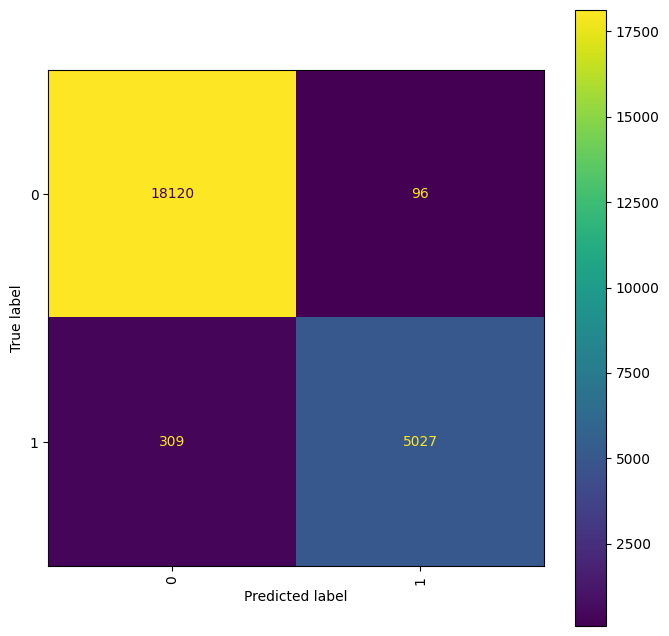

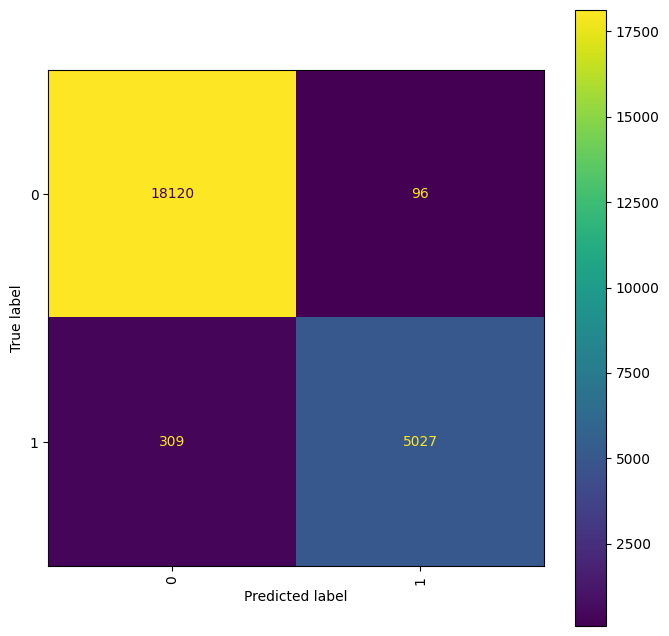

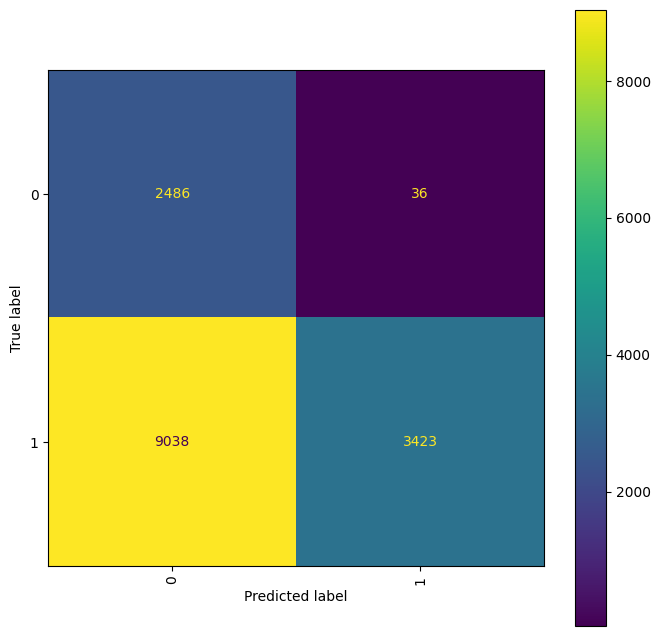

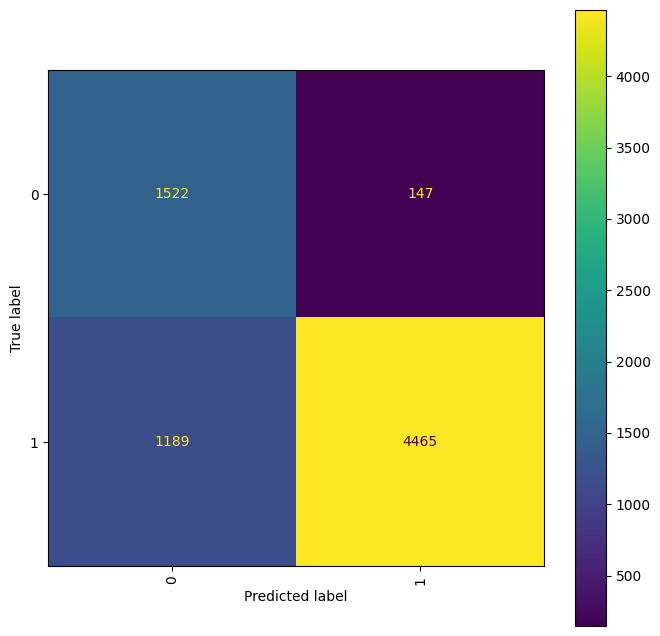

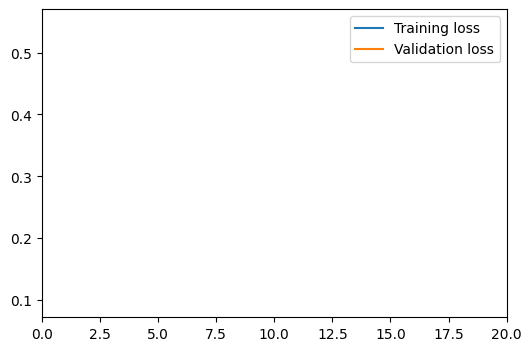

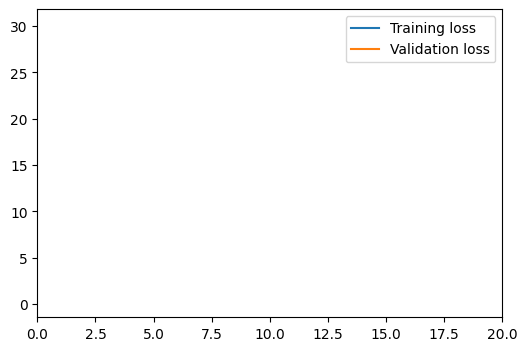

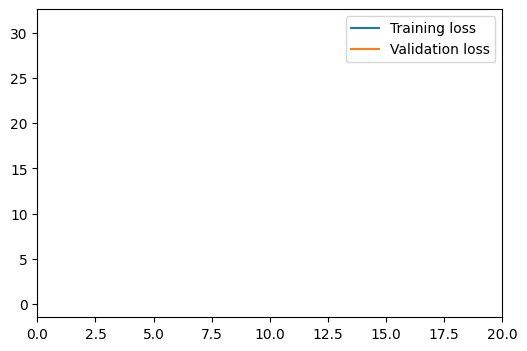

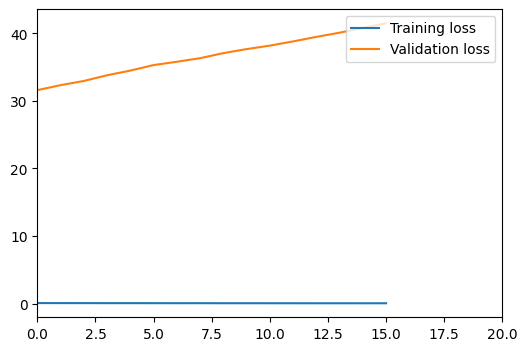

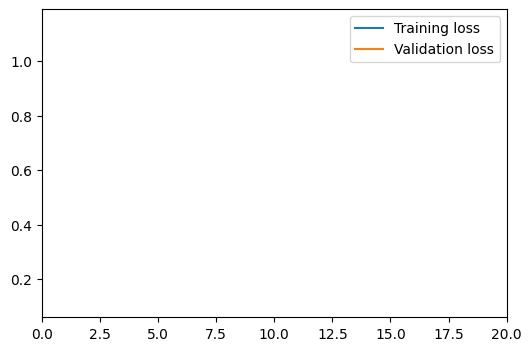

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [184]:
epochs = 20

# config for progress bar
mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']
x = []

training_losses = []
validation_losses = []

valid_mean_min = np.Inf
classes = ['normal','stfu']
# oov

class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

actual = []
predictions = []




for epoch in mb:
  x.append(epoch)
  # Evaluate
  model.train()
  total_loss = torch.Tensor([0.0]).to(device)
  #pbar = tqdm(train_dl, total=len(train_dl), position=0, desc="Training", leave=True)
  for batch in progress_bar(train_dl, parent=mb):
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    # get mel spectograms
    mel_audio_data = audio_transform(audio_data)
    # do zmuv transform
    mel_audio_data = zmuv_transform(mel_audio_data)
    predicted_scores = model(mel_audio_data.unsqueeze(1))
    # get loss
    loss = criterion(predicted_scores.squeeze(), labels.float())
    #loss = criterion(predicted_scores, labels)

    optimizer.zero_grad()
    model.zero_grad()

    # backward propagation
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        total_loss += loss
      
  for group in optimizer.param_groups:
    group["lr"] *= lr_decay

  mean = total_loss / len(train_dl)
  training_losses.append(mean.cpu())
  
  model.eval()
    # iterate over test data
  test_loss = 0
  pbar = tqdm.tqdm_notebook(test_dl, total=len(test_dl), position=0, desc="Testing", leave=True)
  for batch in pbar:
        # move tensors to GPU if CUDA is available
        audio_data = batch['audio'].to(device)
        labels = batch['labels'].to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        mel_audio_data = audio_transform(audio_data)
        # do zmuv transform
        mel_audio_data = zmuv_transform(mel_audio_data)
        output = model(mel_audio_data.unsqueeze(1))
        # calculate the batch loss
        
        loss = criterion(output.squeeze(), labels.float())
        #loss = criterion(output, labels)
        # update test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        pred = (torch.sigmoid(output)>0.5)*1
        #_, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(labels.shape[0]):
            label = labels.data[i]
            class_correct[label.long()] += correct[i].item()
            class_total[label.long()] += 1
            # for confusion matrix    
            actual.append(classes[labels.data[i].long().item()])
            predictions.append(classes[pred.data[i].item()])
        
# plot confusion matrix
  cm = confusion_matrix(actual, predictions, labels=classes)
  print(classification_report(actual, predictions))
  cmp = ConfusionMatrixDisplay(cm)
  val_mean = test_loss / len(test_dl)
  validation_losses.append(val_mean)

  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean:.6f} with lr {group['lr']:.6f}")

  # save model if validation loss has decreased
  if val_mean <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean))
      torch.save(model.state_dict(), 'checkpoint/stfu.pt')
      valid_mean_min = val_mean

In [76]:
train_on_gpu = 'True'

In [216]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0
classes = ['normal','stfu']
# oov

class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

actual = []
predictions = []

model.eval()
# iterate over test data
pbar = tqdm.tqdm_notebook(test_dl, total=len(test_dl), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    mel_audio_data = audio_transform(audio_data)
    # do zmuv transform
    mel_audio_data = zmuv_transform(mel_audio_data)
    output = model(mel_audio_data.unsqueeze(1))
    # calculate the batch loss
    loss = criterion(output.squeeze(), labels.float())
    # update test loss 
    test_loss += loss.item()*audio_data.size(0)
    # convert output probabilities to predicted class
    pred = (torch.sigmoid(output)>0.5)*1
    #_, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(labels.shape[0]):
        label = labels.data[i]
        class_correct[label.long()] += correct[i].item()
        class_total[label.long()] += 1
        # for confusion matrix    
        actual.append(classes[labels.data[i].long().item()])
        predictions.append(classes[pred.data[i].item()])
        
# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=classes)
print(classification_report(actual, predictions))
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')


# average test loss
test_loss = test_loss/len(test_ds)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [48, 1, 8, 16], expected input[1, 64, 91, 40] to have 1 channels, but got 64 channels instead

In [190]:
test_ds

,path,sentence,timestamps,flag
0,en-US_004NOMVGP0_85153_True.wav,it's called ur mom being fucked,"{'Its': {'start': 0.06, 'end': 0.3}, 'called':...",True
1,en-US_008A2TOMAT_196782_True.wav,son of a fucking whore,"{'Son': {'start': 0.1, 'end': 0.32}, 'of': {'s...",True
2,en-US_008E2KYNNP_131758_True.wav,look at it go motherfucker,"{'Look': {'start': 0.28, 'end': 0.5}, 'at': {'...",True
3,en-US_008KASX3NT_46781_True.wav,i hate this pinballl shit,"{'I': {'start': 0.06, 'end': 0.26}, 'hate': {'...",True
4,en-US_00EDDNIP6X_127419_True.wav,very noob motherfucker,"{'Very': {'start': 0.1, 'end': 0.4}, 'new': {'...",True
...,...,...,...,...
7318,en-US_ZYZJ351CN7_178414_True.wav,so everyone that fucks your tiny ass,"{'So': {'start': 0.06, 'end': 0.26}, 'everyone...",True
7319,en-US_ZZKMUM4AG5_208193_True.wav,i will rape your little ass,"{'I': {'start': 0.0, 'end': 0.16}, 'will': {'s...",True
7320,en-US_ZZNQNITLL2_179669_True.wav,wheres your meepo now cunt?,"{'Wheres': {'start': 0.06, 'end': 0.36}, 'your...",True
7321,en-US_ZZNZU3Z3ZP_34298_True.wav,got fucked in the ass,"{'got': {'start': 0.04, 'end': 0.22}, 'fucked'...",True


In [236]:
window_size_ms = 750
max_length = int(window_size_ms/1000 * sr)

sample = test_ds.iloc[2]
print(sample['sentence'])
audio_data = librosa.core.load(data_path+sample['path'], sr=sr, mono=True)[0]
# get the label and its audio
label, audio_data = compute_labels(sample, audio_data)
audio_data_length = audio_data.size / sr * 1000 #ms

if audio_data_length > window_size_ms:
    # randomly trim either at start and end
    if random.random() < 0.5:
      audio_data = audio_data[:max_length]
    else:
      audio_data = audio_data[audio_data.size-max_length:]

# pad with zeros
if audio_data_length < window_size_ms:
    # randomly either append or prepend
    if random.random() < 0.5:
      audio_data = np.append(audio_data, np.zeros(int(max_length - audio_data.size)))
    else:
      audio_data = np.append(np.zeros(int(max_length - audio_data.size)), audio_data)
audio_data = torch.tensor(audio_data).to(device)
mel_audio_data = audio_transform(audio_data)
mel_audio_data = zmuv_transform(mel_audio_data)
output = model(mel_audio_data.unsqueeze(0).unsqueeze(0))
pred = (torch.sigmoid(output)>0.5)*1
pred

look at it go motherfucker


tensor([[1]], device='cuda:0')

In [223]:
classes

['normal', 'stfu']